# 1. 安裝 grad-cam 套件

In [1]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 13.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.0-py3-none-any.whl size=38070 sha256=32bd08e76ba6ce18ede6fd3c4c0eb292b39e3344a98613ee79bcd8dc6bc5ce32
  Stored in directory: /root/.cache/pip/wheels/5b/e5/3d/8548241d5cffe53ad1476c566a61ad9bf09cc61a9430f09726
Successfully built grad-cam


# 2. 下載測試圖片

In [2]:
# 狗圖
!wget https://cdn.britannica.com/79/232779-050-6B0411D7/German-Shepherd-dog-Alsatian.jpg -O dog.jpg

--2024-01-19 01:19:18--  https://cdn.britannica.com/79/232779-050-6B0411D7/German-Shepherd-dog-Alsatian.jpg
Resolving cdn.britannica.com (cdn.britannica.com)... 13.35.35.45, 13.35.35.68, 13.35.35.91, ...
Connecting to cdn.britannica.com (cdn.britannica.com)|13.35.35.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344524 (336K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 336.45K  --.-KB/s    in 0.01s   

2024-01-19 01:19:18 (25.3 MB/s) - ‘dog.jpg’ saved [344524/344524]



In [3]:
# 貓圖
!wget https://www.pbs.org/newshour/app/uploads/2017/06/cats_AdobeStock_124353454-1024x685.jpeg -O cat.jpg

--2024-01-19 01:19:18--  https://www.pbs.org/newshour/app/uploads/2017/06/cats_AdobeStock_124353454-1024x685.jpeg
Resolving www.pbs.org (www.pbs.org)... 18.244.214.46, 18.244.214.10, 18.244.214.5, ...
Connecting to www.pbs.org (www.pbs.org)|18.244.214.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 144707 (141K) [image/jpeg]
Saving to: ‘cat.jpg’

cat.jpg             100%[===================>] 141.32K   471KB/s    in 0.3s    

2024-01-19 01:19:19 (471 KB/s) - ‘cat.jpg’ saved [144707/144707]



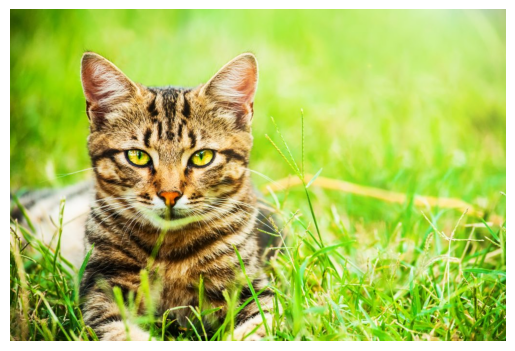

In [4]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# 載入圖片(需要載入)
img_path = 'cat.jpg'
# 調整圖片大小
img = Image.open(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

# 3. 推論圖像

In [5]:
import torch
import cv2
import numpy as np
import requests
import torchvision.transforms as transforms
from torchvision.models import resnet101, ResNet101_Weights
from PIL import Image

COLORS = np.random.uniform(0, 255, size=(80, 3))

# 載入測試圖片
img = np.array(Image.open("cat.jpg"))

# 調整圖片大小
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()

# 圖片正規化
img = np.float32(img) / 255
transform = transforms.ToTensor()
# transform(img) # [3, 640, 640]
# .unsqueeze() 在最前面加上一個維度 -> [1, 3, 640, 640]
tensor = transform(img).unsqueeze(0)

# 模型權重
weights = ResNet101_Weights.IMAGENET1K_V1
# 載入模型與權重
model = resnet101(weights=ResNet101_Weights.IMAGENET1K_V1)
# 將模型設定為評估模式
model.eval()
model.cpu()

# 使用模型推論
prediction = model(tensor)

# 獲得預測结果
label = prediction.argmax().item()
category_name = weights.meta["categories"][label]

# 印出推論结果
print(category_name)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:02<00:00, 68.9MB/s]


tiger cat


In [6]:
# 查看模型結構
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
# 提取目標卷積層
target_layer = [model.layer4[-1].conv3]
target_layer

[Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)]

# 4. 使用 Grad-CAM 取得模型關注區域

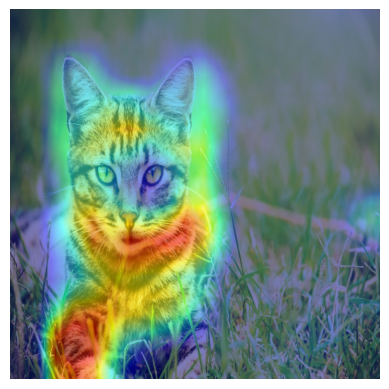

In [8]:
# 載入相關套件
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image

# GradCAM 輸入模型、可視化目標層
gradcam = GradCAM(model, target_layer)
# 使用 cam 取得熱力圖
grayscale_cam = gradcam(tensor)[0, :, :]
# 將熱力圖和原圖交疊
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)

# 顯示圖片
plt.axis('off')
plt.imshow(cam_image)
plt.show()